# Exercise - Blog Post Pipeline - SOLUTION

In this exercise, you will implement a proper multi-agent workflow as pipeline using LangGraph to orchestrate the blog creation process, replacing the manual message passing approach.

**Challenge**

You're building a blog creation system with multiple specialized agents:
- Intake Agent: Plans the blog structure
- Researcher Agent: Gathers information
- Writer Agent: Creates the content
- Reviewer Agent: Edits and optimizes
- Publisher Agent: Finalizes and publishes

Your solution should create a proper LangGraph workflow that:
- Manages state automatically between agents
- Eliminates manual message accumulation
- Provides a clean, maintainable architecture
- Allows for easy workflow modifications

## 0. Setup

In [1]:
import os
from typing import Dict, Any, List, Annotated
from IPython.display import Image, display
from urllib.parse import urlparse
import nest_asyncio
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    AIMessage
)
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.runnables.graph import MermaidDrawMethod
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from tavily import TavilyClient

In [2]:
nest_asyncio.apply()

In [3]:
load_dotenv()

True

In [4]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    base_url="https://openai.vocareum.com/v1",
    api_key=os.getenv("VOCAREUM_API_KEY")
)

In [5]:
tavily_client = TavilyClient(
    api_key=os.getenv("TAVILY_API_KEY")
)

## 1. Define the state structure for the blog workflow

Create a custom state class that extends 
MessagesState to include blog-specific fields. This is how an agent communicates with the downstream ones.


In [6]:
class BlogState(MessagesState):
    """State for the blog creation workflow."""
    query: HumanMessage
    topic: str
    title: str
    audience: str
    sections: List[str]
    keywords: List[str]
    research: List[Dict[str, Any]]
    draft_markdown: str
    references_markdown: str
    final_markdown: str
    seo_score: int
    publish_status: str

## 2. Create the specialized agents

Each agent should have its own tools and system prompt. So, define the tools, agents and their prompt instructions.


**Tools**

In [7]:
@tool
def outline_topic(topic: str) -> Dict[str, Any]:
    """
    Creates a pragmatic outline for a blog post given a topic.

    Args:
        topic (str): The domain/area/technology (e.g., "LangGraph multi-agent systems").

    Returns:
        Dict[str, Any]: A dictionary with:
            - title (str): Suggested working title.
            - audience (str): Target reader profile.
            - sections (List[str]): Ordered list of section headings.

    Example:
        >>> outline_topic(topic="LangGraph multi-agent systems")
        {'title': 'LangGraph multi-agent systems: What It Is, Why It Matters, and How To Start',
         'audience': 'Practitioners and curious newcomers',
         'sections': ['Introduction', 'Why ... matters right now', ...]}
    """
    base = topic.strip().rstrip(".")
    title = f"{base}: What It Is, Why It Matters, and How To Start"
    audience = "Practitioners and curious newcomers"
    sections = [
        "Introduction",
        f"Why {base} matters right now",
        f"Core concepts in {base}",
        f"Practical getting-started guide for {base}",
        "Common pitfalls and best practices",
        f"Trends and the future of {base}",
        "Conclusion and next steps",
    ]
    return {"title": title, "audience": audience, "sections": sections}

In [8]:
@tool
def generate_keywords(topic: str, limit: int = 12) -> List[str]:
    """
    Generates a compact keyword set for SEO checks based on a topic.

    Args:
        topic (str): The domain/area/technology to derive keywords from.
        limit (int, optional): Maximum number of keywords to return. Defaults to 12.

    Returns:
        List[str]: A list of keyword phrases ordered by relevance heuristics.

    Example:
        >>> generate_keywords(topic="LangGraph multi-agent systems", limit=8)
        ['langgraph multi-agent systems', 'langgraph multi-agent systems tutorial', ...]
    """
    root = topic.lower().strip()
    extras = [
        f"{root} tutorial", f"{root} guide", f"{root} best practices",
        f"{root} examples", f"{root} use cases", f"{root} vs alternatives",
        f"{root} performance", f"{root} scalability",
        f"{root} architecture", f"{root} tools", f"{root} pitfalls"
    ]
    # Deduplicate while preserving order
    seen = set()
    out = []
    for k in [root] + extras:
        if k not in seen:
            seen.add(k)
            out.append(k)
        if len(out) >= limit: break
    return out

In [9]:
@tool
def web_search(question:str)->Dict[str, Any]:
    """
    Performs a web search and returns top search results for a given query.

    Args:
        question (str): A query to be searched.

    Returns:
        Dict[str, Any]: A dictionary with a 'results' list where each item is a dict containing:
            - url (str): The result URL.
            - title (str): The page title.
            - content (str): A content snippet or summary.
            - score (float): Relevance score from the search provider.

    Example:
        >>> web_search(question="LangGraph multi-agent patterns")
        {'results': [{'url': 'https://...', 'title': '...', 'content': '...', 'score': 0.82}, ...]}
    """
    response = tavily_client.search(
        query=question,
        max_results=5,
    )
    return response

In [10]:
@tool
def dedupe_by_domain(results: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Deduplicates research results by domain, keeping the strongest items per domain.

    Args:
        results (List[Dict[str, Any]]): A list of search result objects where each item contains:
            - url (str): Result URL (used to extract domain).
            - title (str): Page title.
            - content (str): Snippet or summary.
            - score (float): Relevance score.

    Returns:
        List[Dict[str, Any]]: A list of results with at most 'max_per_domain' per domain,
        sorted within each domain by descending 'score' (then title length as tie-breaker).

    Notes:
        If a URL is missing or unparsable, the domain is treated as "unknown".

    Example:
        >>> dedupe_by_domain(search_payload['results'])
        [{'url': 'https://a.com/...', ...}, {'url': 'https://b.org/...', ...}]
    """
    by_domain: Dict[str, List[Dict[str, Any]]] = {}
    for r in results or []:
        domain = urlparse(r.get("url", "")).netloc or "unknown"
        by_domain.setdefault(domain, []).append(r)

    cleaned = []
    max_per_domain = 1
    for _, items in by_domain.items():
        items = sorted(items, key=lambda x: (x.get("score", 0), len(x.get("title", ""))), reverse=True)
        cleaned.extend(items[:max_per_domain])
    return cleaned

In [11]:
@tool
def format_references(results: List[Dict[str, Any]]) -> str:
    """
    Formats research results into a Markdown footnotes block.

    Args:
        results (List[Dict[str, Any]]): A list of research items with fields:
            - title (str)
            - url (str)

    Returns:
        str: Markdown string with one footnote per line using the format:
             "[^n]: {title} — {url}"

    Example:
        >>> format_references([{'title':'Doc','url':'https://...'}])
        '[^1]: Doc — https://...'
    """
    lines = []
    for i, r in enumerate(results or [], start=1):
        title = r.get("title", "Untitled")
        url = r.get("url", "")
        lines.append(f"[^{i}]: {title} — {url}")
    return "\n".join(lines)


In [12]:
@tool
def estimate_read_time(markdown_text: str, wpm: int = 225) -> Dict[str, Any]:
    """
    Estimates reading time and word count for a Markdown draft.

    Args:
        markdown_text (str): The full Markdown content to analyze.
        wpm (int, optional): Reading speed in words per minute. Defaults to 225.

    Returns:
        Dict[str, Any]: A dictionary with:
            - word_count (int): Total number of words.
            - minutes (int): Estimated whole minutes to read (minimum of 1).

    Example:
        >>> estimate_read_time("# Title\\n\\nSome text.")
        {'word_count': 3, 'minutes': 1}
    """
    import re
    words = re.findall(r"\b\w+\b", markdown_text or "")
    wc = len(words)
    minutes = max(1, round(wc / max(100, wpm)))
    return {"word_count": wc, "minutes": minutes}

In [13]:
@tool
def markdown_lint(md: str) -> Dict[str, Any]:
    """
    Runs a simple Markdown lint pass for structure and readability issues.

    Args:
        md (str): Markdown content to lint.

    Returns:
        Dict[str, Any]: A dictionary with:
            - ok (bool): True if no issues found, else False.
            - issues (List[str]): Human-readable problem descriptions.

    Checks:
        - Ensures the document starts with a single H1 ('# ').
        - Warns if footnote markers are present but definitions are missing.
        - Flags overly long paragraphs (very rough heuristic).

    Example:
        >>> markdown_lint("No title")
        {'ok': False, 'issues': ['Missing H1 title at the very top (use '# Title').']}
    """
    issues = []
    if not md.strip().startswith("# "):
        issues.append("Missing H1 title at the very top (use '# Title').")

    if "[^" in md and "]: " not in md:
        issues.append("Footnote marker used but no footnote definitions present.")

    for idx, para in enumerate([p for p in md.split("\n\n") if p.strip()], start=1):
        if len(para) > 1200:
            issues.append(f"Paragraph {idx} is very long; consider splitting.")

    return {"ok": len(issues) == 0, "issues": issues}

In [14]:
@tool
def seo_score(md: str, keywords: List[str]) -> Dict[str, Any]:
    """
    Computes a naive SEO score (0-100) based on keyword distribution.

    Args:
        md (str): Markdown content to score.
        keywords (List[str]): Target keywords/phrases to check for.

    Returns:
        Dict[str, Any]: A dictionary with:
            - score (int): SEO score (capped at 100).
            - title_hits (int): Count of keywords present in the H1 title.
            - heading_hits (int): Count of keywords found across headings.
            - body_hits (int): Count of keywords found in the full text.
            - keywords_checked (List[str]): Echo of the keywords analyzed.

    Scoring:
        - Title matches weighted 20 points each.
        - Heading matches weighted 6 points each.
        - Body matches weighted 2 points each.

    Example:
        >>> seo_score(md="# LangGraph Guide", keywords=["langgraph"])
        {'score': 28, 'title_hits': 1, 'heading_hits': 0, 'body_hits': 1, 'keywords_checked': ['langgraph']}
    """
    import re
    text = md.lower()
    title = ""
    headings = []
    for line in md.splitlines():
        if line.startswith("# "):
            title = line.lower()
        if line.startswith("#"):
            headings.append(line.lower())

    def contains(k: str, hay: str) -> bool:
        return re.search(rf"\b{re.escape(k)}\b", hay) is not None

    title_hits = sum(1 for k in keywords if contains(k, title))
    heading_hits = sum(1 for k in keywords if any(contains(k, h) for h in headings))
    body_hits = sum(1 for k in keywords if contains(k, text))

    score = min(100, title_hits * 20 + heading_hits * 6 + body_hits * 2)
    return {
        "score": score,
        "title_hits": title_hits,
        "heading_hits": heading_hits,
        "body_hits": body_hits,
        "keywords_checked": keywords[:],
    }

In [15]:
@tool
def publish_blog(body_md: str) -> Dict[str, Any]:
    """
    Publishes the final blog post (mock implementation).

    Args:
        body_md (str): Final Markdown body content to publish.

    Returns:
        Dict[str, Any]: A dictionary indicating publication status:
            - status (str): Always 'published' in this mock implementation.

    Side Effects:
        Prints the blog title and body to stdout, followed by a status line.

    Example:
        >>> publish_blog(title="My Post", body_md="# My Post\\n\\nHello")
        {'status': 'published'}
    """
    print("\n=== PUBLISHING BLOG ===")
    print(body_md)
    print("\n=== STATUS: published ===")
    return {"status": "published"}

**Agents**

In [16]:
intake_agent = create_react_agent(
    name="intake_agent",
    prompt=SystemMessage(
        content=(
            "You are a pragmatic content planner. "
            "Given a domain/area/technology topic, produce a blog plan: "
            "a clear working title, target audience, and a section outline. "
            "Use tools to create the outline and initial keyword set. "
            "Return ONLY JSON with keys: topic, title, audience, sections, keywords."
        )
    ),
    model=llm,
    tools=[outline_topic, generate_keywords],
)

In [17]:
researcher_agent = create_react_agent(
    name="researcher_agent",
    prompt=SystemMessage(
        content=(
            "You're a senior marketing researcher. "
            "Given the topic and optionally other sections, "
            "find RECENT, high-signal web information about the topic. "
            "Call web_search at least once with a good query; "
            "then call dedupe_by_domain to remove duplicates. "
            "Return ONLY JSON with key 'research', an array of items "
            "each like {url,title,content,score} (deduped)."
        )
    ),
    model=llm,
    tools=[web_search, dedupe_by_domain],
)

In [18]:
writer_agent = create_react_agent(
    name="writer_agent",
    prompt=SystemMessage(
        content=(
            "You are a seasoned technical blogger. "
            "Write a polished Markdown blog post using title, sections, "
            "and research (array of {url,title,content,score}). "
            "Requirements:\n"
            " - Begin with an H1 (= the title).\n"
            " - Add a short abstract (1-2 sentences), then follow the sections.\n"
            " - Use bullets, code fences, and examples when helpful.\n"
            " - Use footnote-style citations [^1], [^2] inline whenever claims come from research.\n"
            " - Append '## References' followed by footnotes generated via the references tool.\n"
            " - Add an estimated reading time line near the top.\n"
            "Workflow:\n"
            " 1) Draft the post body.\n"
            " 2) Call estimate_read_time on the draft and insert a line like '_Estimated reading time: X min_'.\n"
            " 3) Call format_references with the same research list to create footnotes.\n"
            "Return ONLY JSON with keys: draft_markdown, references_markdown."
        )
    ),
    model=llm,
    tools=[estimate_read_time, format_references],
)

In [19]:
reviewer_agent = create_react_agent(
    name="reviewer_agent",
    prompt=SystemMessage(
        content=(
            "You are a meticulous copy editor. "
            "Input: draft_markdown, keywords, references_markdown. "
            "Tasks:\n"
            " 1) Ensure '## References' exists at the end and merge references_markdown if missing.\n"
            " 2) Call markdown_lint on the draft; then fix issues inline (H1 title, footnotes, long paragraphs).\n"
            " 3) Call seo_score; make small, high-quality edits to improve the score "
            "    without keyword stuffing (preserve voice and clarity).\n"
            "Output: Return ONLY JSON with keys: final_markdown, seo, lint."
        )
    ),
    model=llm,
    tools=[markdown_lint, seo_score],
)

In [20]:
publisher_agent = create_react_agent(
    name="publisher_agent",
    prompt=SystemMessage(
        content=(
            "You are a release manager. "
            "Publish the finalized blog post using the provided tool. "
            "Input: title and final_markdown (produced by the reviewer). "
            "Return ONLY JSON with keys: publish_status."
        )
    ),
    model=llm,
    tools=[publish_blog],
)

## 3. Create the workflow nodes that integrate the agents

Each node should invoke the corresponding agent and update the state appropriately

**Pydantic Models for parsing outputs**

In [21]:
class BlogPlan(BaseModel):
    """Output from the intake agent"""
    topic: Annotated[str, Field(description="The main topic of the blog post")]
    title: Annotated[str, Field(description="A clear, working title for the blog post")]
    audience: Annotated[str, Field(description="Target audience description")]
    sections: Annotated[List[str], Field(description="List of section headings for the blog outline")]
    keywords: Annotated[List[str], Field(description="List of relevant keywords for SEO")]

In [22]:
class ResearchData(BaseModel):
    """Output from the researcher agent"""
    research: Annotated[List[Dict[str, Any]], Field(description="List of research items with url, title, content, and score")]

In [23]:
class ResearchItem(BaseModel):
    """Individual research item with metadata"""
    url: Annotated[str, Field(description="URL of the research source")]
    title: Annotated[str, Field(description="Title of the research content")]
    content: Annotated[str, Field(description="Extracted content from the source")]
    score: Annotated[float, Field(description="Relevance score from 0.0 to 1.0")]

class ResearchData(BaseModel):
    """Output from the researcher agent"""
    research: Annotated[List[ResearchItem], Field(description="List of research items")]


In [24]:
class ContentDraft(BaseModel):
    """Output from the writer agent"""
    draft_markdown: Annotated[str, Field(description="The complete blog post in markdown format")]
    references_markdown: Annotated[str, Field(description="Formatted references section")]

In [25]:
class ReviewedContent(BaseModel):
    """Output from the reviewer agent"""
    final_markdown: Annotated[str, Field(description="The final, reviewed blog post")]
    seo_score: Annotated[int, Field(description="SEO score from 0-100")]
    lint_issues: Annotated[List[str], Field(description="List of any linting issues found and fixed")]

In [26]:
class PublicationStatus(BaseModel):
    """Output from the publisher agent"""
    publish_status: Annotated[str, Field(description="Status of the publication process")]

**Nodes**

In [27]:
def intake_node(state: BlogState) -> BlogState:
    """Node for the intake agent to plan the blog."""
    print("Starting intake agent...")
    
    result = intake_agent.invoke(
        input={
            "messages": [
                state["query"]
            ]
        }
    )
    messages = result["messages"]
    last_ai_message:AIMessage = messages[-1]

    llm_with_structure = llm.with_structured_output(BlogPlan)
    structured_output:BlogPlan = llm_with_structure.invoke(last_ai_message.content)
    
    print(f"message: {last_ai_message.content[:20]}...")
    print("Done!\n")

    return {
        "messages": [state["query"]] + messages,
        "topic": structured_output.topic,
        "title": structured_output.title,
        "audience": structured_output.audience,
        "sections": structured_output.sections,
        "keywords": structured_output.keywords,
    }

In [28]:
def research_node(state: BlogState) -> BlogState:
    """Node for the researcher agent to gather information."""
    print("Starting researcher agent...")
    
    context_message = f"Research topic: {state['topic']}\nSections: {', '.join(state['sections'])}"

    result = researcher_agent.invoke(
        input={
            "messages": [
                state["query"],
                AIMessage(content=context_message)
            ]
        }
    )
    messages = result["messages"]
    last_ai_message:AIMessage = messages[-1]
    
    llm_with_structure = llm.with_structured_output(ResearchData)
    structured_output:ResearchData = llm_with_structure.invoke(last_ai_message.content)
    
    print(f"message: {last_ai_message.content[:20]}...")
    print("Done!\n")

    return {
        "messages": messages,
        "research": structured_output.research,
    }


In [29]:
def writer_node(state: BlogState) -> BlogState:
    """Node for the writer agent to create content."""
    print("Starting writer agent...")

    context_message = f"Title: {state['title']}\nSections: {', '.join(state['sections'])}\nResearch: {len(state['research'])} items"
    
    result = writer_agent.invoke(
        input={
            "messages": [
                state["query"],
                AIMessage(content=context_message)
            ]
        }
    )
    messages = result["messages"]
    last_ai_message:AIMessage = messages[-1]

    llm_with_structure = llm.with_structured_output(ContentDraft)
    structured_output:ContentDraft = llm_with_structure.invoke(last_ai_message.content)
    
    print(f"message: {last_ai_message.content[:20]}...")
    print("Done!\n")

    return {
        "messages": messages,
        "draft_markdown": structured_output.draft_markdown,
        "references_markdown": structured_output.references_markdown,
    }


In [30]:
def reviewer_node(state: BlogState) -> BlogState:
    """Node for the reviewer agent to edit and optimize."""
    print("Starting review agent...")

    context_message = f"Draft: {state['draft_markdown']}...\nKeywords: {', '.join(state['keywords'])}"
    
    result = reviewer_agent.invoke(
        input={
            "messages": [
                state["query"],
                AIMessage(content=context_message)
            ]
        }
    )
    messages = result["messages"]
    last_ai_message:AIMessage = messages[-1]

    llm_with_structure = llm.with_structured_output(ReviewedContent)
    structured_output:ReviewedContent = llm_with_structure.invoke(last_ai_message.content)
    
    print(f"message: {last_ai_message.content[:20]}...")
    print("Done!\n")
    
    return {
        "messages": messages,
        "final_markdown": structured_output.final_markdown,
        "seo_score": structured_output.seo_score,
    }

In [31]:
def publisher_node(state: BlogState) -> BlogState:
    """Node for the publisher agent to finalize and publish."""
    print("Starting publisher agent...")
    
    context_message = f"Title: {state['title']}\nContent: {state['final_markdown']}"
    
    result = publisher_agent.invoke(
        input={
            "messages": [
                state["query"],
                AIMessage(content=context_message)
            ]
        }
    )
    messages = result["messages"]
    last_ai_message:AIMessage = messages[-1]
    
    llm_with_structure = llm.with_structured_output(PublicationStatus)
    structured_output:PublicationStatus = llm_with_structure.invoke(last_ai_message.content)
    
    print(f"message: {last_ai_message.content[:20]}...")
    print("Done!\n")
    
    return {
        "messages": messages,
        "publish_status": structured_output.publish_status,
    }

## 4. Build the LangGraph workflow

Create the workflow and add nodes and edges


In [32]:
workflow = StateGraph(BlogState)

In [33]:
workflow.add_node("intake", intake_node)
workflow.add_node("research", research_node)
workflow.add_node("writer", writer_node)
workflow.add_node("reviewer", reviewer_node)
workflow.add_node("publisher", publisher_node)

In [34]:
workflow.add_edge(START, "intake")
workflow.add_edge("intake", "research")
workflow.add_edge("research", "writer")
workflow.add_edge("writer", "reviewer")
workflow.add_edge("reviewer", "publisher")
workflow.add_edge("publisher", END)

## 5. Compile and test the workflow

In [35]:
graph = workflow.compile()

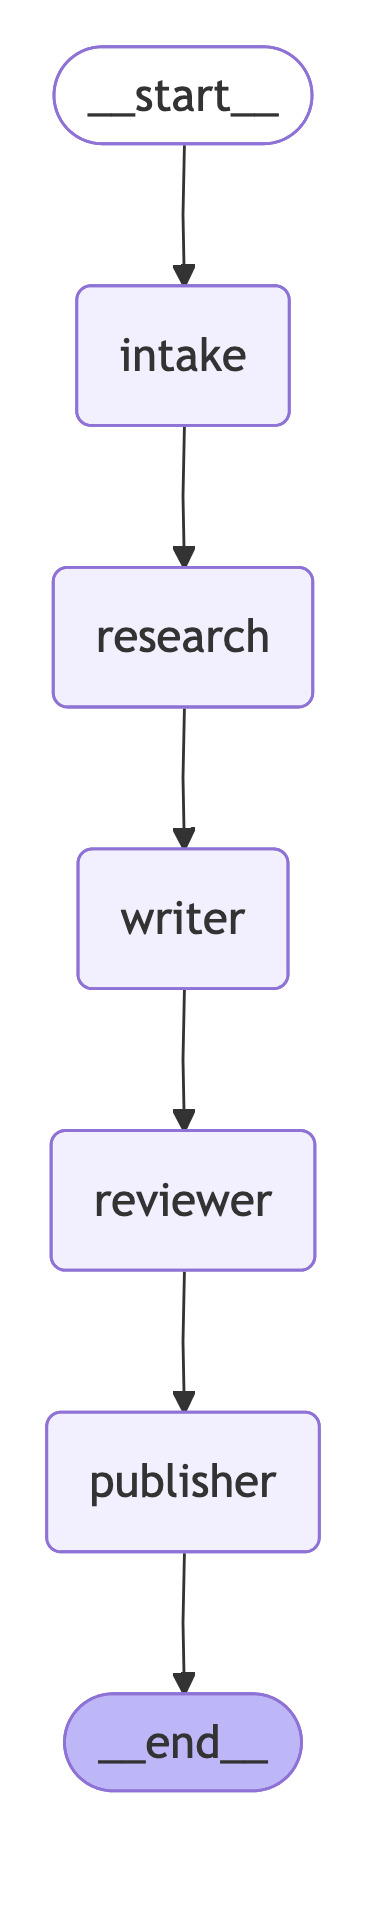

In [36]:
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.PYPPETEER
        )
    )
)

In [37]:
user_message = HumanMessage(
    content = "I want a blog post about AI Agents"
)

In [38]:
result = graph.invoke(
    input={
        "query": user_message,
    }
)

Starting intake agent...
message: {
  "topic": "AI Age...
Done!

Starting researcher agent...
message: {
  "research": [
  ...
Done!

Starting writer agent...
message: {
  "draft_markdown"...
Done!

Starting review agent...
message: {
  "final_markdown"...
Done!

Starting publisher agent...

=== PUBLISHING BLOG ===
# AI Agents: What It Is, Why It Matters, and How To Start

AI agents are transforming the way we interact with technology, automating tasks and providing intelligent solutions across various domains. This post explores the significance of AI agents, their core concepts, and how to get started with them.

_Estimated reading time: 2 min_

## Why AI Agents Matter Right Now

- **Increased Efficiency**: AI agents can automate repetitive tasks, allowing humans to focus on more complex problems.
- **Enhanced Decision Making**: They analyze vast amounts of data quickly, providing insights that can lead to better decision-making.
- **Personalization**: AI agents can tailor experience

## 6. Verify the workflow execution

Check that the state was properly managed throughout the workflow


In [39]:
result["publish_status"]

'published'

In [40]:
result["final_markdown"]

'# AI Agents: What It Is, Why It Matters, and How To Start\n\nAI agents are transforming the way we interact with technology, automating tasks and providing intelligent solutions across various domains. This post explores the significance of AI agents, their core concepts, and how to get started with them.\n\n_Estimated reading time: 2 min_\n\n## Why AI Agents Matter Right Now\n\n- **Increased Efficiency**: AI agents can automate repetitive tasks, allowing humans to focus on more complex problems.\n- **Enhanced Decision Making**: They analyze vast amounts of data quickly, providing insights that can lead to better decision-making.\n- **Personalization**: AI agents can tailor experiences to individual users, improving customer satisfaction and engagement.\n\n## Core Concepts in AI Agents\n\n- **Autonomy**: AI agents operate independently, making decisions based on their programming and learned experiences.\n- **Adaptability**: They can learn from new data and experiences, improving thei

In [41]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

I want a blog post about AI Agents
================================== Ai Message ==================================
Name: intake_agent
Tool Calls:
  outline_topic (call_70P2cLhJrOoIwKaaCLLoYNsD)
 Call ID: call_70P2cLhJrOoIwKaaCLLoYNsD
  Args:
    topic: AI Agents
  generate_keywords (call_B9RF0i2IAk2xXW2yOEVEArcm)
 Call ID: call_B9RF0i2IAk2xXW2yOEVEArcm
  Args:
    topic: AI Agents
================================= Tool Message =================================
Name: outline_topic

{"title": "AI Agents: What It Is, Why It Matters, and How To Start", "audience": "Practitioners and curious newcomers", "sections": ["Introduction", "Why AI Agents matters right now", "Core concepts in AI Agents", "Practical getting-started guide for AI Agents", "Common pitfalls and best practices", "Trends and the future of AI Agents", "Conclusion and next steps"]}
================================= Tool Message ===============